In [12]:
import os
import numpy as np
import librosa
import copy
import scipy
from scipy.spatial.distance import directed_hausdorff
from scipy.io import wavfile
from pyttsx3 import init
import pyttsx3
import matplotlib.pyplot as plt

In [5]:
def load_text_data(file_path="Signal1.txt"):
    return np.loadtxt(file_path)


def convert_text_to_speech(text, output_file):
    engine = pyttsx3.init()
    engine.save_to_file(text, "temp.wav")
    engine.runAndWait()
    os.rename("temp.wav", output_file)


def save_signal_to_wav(data, file_path, sampling_rate=22050): 
    scipy.io.wavfile.write(file_path, sampling_rate, data)


def load_wav_data(file_path):
    sampling_rate, signal = scipy.io.wavfile.read(file_path)
    trimmed_signal, _, _ = trim_signal(signal)
    return trimmed_signal.astype(np.float64), sampling_rate


def trim_signal(signal, trim_threshold=50):
    signal[np.abs(signal) < trim_threshold] = 0
    start_trimmed = np.count_nonzero(signal[:len(signal)//2] == 0)
    end_trimmed = np.count_nonzero(signal[len(signal)//2:] == 0)
    return np.trim_zeros(signal), start_trimmed, end_trimmed


def split_data_into_windows(data, window_size=1000, threshold=1600):
    data_copy = copy.deepcopy(data)
    data_copy = np.pad(data_copy, (0, ((len(data_copy) // window_size) + 1) * window_size - len(data_copy)))
    parts, regions = [], []
    base, is_voice, empty_count = 0, False, 0

    for i, window in enumerate(np.array_split(data_copy, len(data_copy) // window_size + 1)):
        max_value = np.max(np.abs(window))

        if empty_count > 1 and is_voice:
            part, start_trim, end_trim = trim_signal(data_copy[base:(i + 1) * window_size], 10)
            parts.append(part)
            regions.append((base + start_trim, base + start_trim + part.size))
            base, is_voice, empty_count = (i + 1) * window_size, False, 0

        elif max_value >= threshold and not is_voice:
            is_voice = True

        elif max_value < threshold and is_voice:
            empty_count += 1

    return ([data_copy], None) if not parts else (parts, regions)


def pad_signals(signal1, signal2):
    trimmed_signal1, _, _ = trim_signal(signal1)
    trimmed_signal2, _, _ = trim_signal(signal2)
    max_size = max(trimmed_signal1.size, trimmed_signal2.size)
    padded_size = ((max_size // 1000) + 1) * 1000
    padded_signal1 = np.pad(trimmed_signal1, (0, padded_size - trimmed_signal1.size))
    padded_signal2 = np.pad(trimmed_signal2, (0, padded_size - trimmed_signal2.size))
    
    return padded_signal1, padded_signal2


def calculate_spectral_distance(feature_x, feature_y):
    dist, _, _ = scipy.spatial.distance.directed_hausdorff(feature_x, feature_y)
    return dist


def extract_audio_features(audio_data, sampling_rate, n_fft=2048):
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sampling_rate, n_fft=n_fft)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(mel_spectrogram))
    spectral_centroid = librosa.feature.spectral_centroid(y=audio_data, n_fft=n_fft)
    chroma = librosa.feature.chroma_stft(y=audio_data, sr=sampling_rate, n_fft=n_fft)    
    return mfccs, spectral_centroid, chroma


def word_statistics(similarity_scores, write=True, percent=False):
    top_guesses = sorted(similarity_scores, key=lambda x: x[1])[:3]
    total = sum(n for (_, n) in top_guesses)
    result = [(word, round(total / freq * 10, 1)) for (word, freq) in top_guesses]
    return result


def create_directory(directory_path, exist_ok=True):
    os.makedirs(directory_path, exist_ok=exist_ok)


def generate_wav_files(word_list, directory):
    for word in word_list:
        output_file = os.path.join(directory, f"{word}.wav")
        
        if not os.path.exists(output_file):
            convert_text_to_speech(word, output_file)
            print(f"WAV file generated for '{word}': {output_file}")
        else:
            print(f"WAV file for '{word}' already exists: {output_file}")

In [6]:
word_list = ["time", "prepare", "solution", "make", "mistake", "no", "the", "probable", "long", "lecture", "method", "disaster", "fail",
"work", "advice", "idea", "succeed", "easy", "is", "for", "give"]
directory = "words"

create_directory(directory)
generate_wav_files(word_list, directory)

WAV file for 'time' already exists: words\time.wav
WAV file for 'prepare' already exists: words\prepare.wav
WAV file for 'solution' already exists: words\solution.wav
WAV file for 'make' already exists: words\make.wav
WAV file for 'mistake' already exists: words\mistake.wav
WAV file for 'no' already exists: words\no.wav
WAV file for 'the' already exists: words\the.wav
WAV file for 'probable' already exists: words\probable.wav
WAV file for 'long' already exists: words\long.wav
WAV file for 'lecture' already exists: words\lecture.wav
WAV file for 'method' already exists: words\method.wav
WAV file for 'disaster' already exists: words\disaster.wav
WAV file for 'fail' already exists: words\fail.wav
WAV file for 'work' already exists: words\work.wav
WAV file for 'advice' already exists: words\advice.wav
WAV file for 'idea' already exists: words\idea.wav
WAV file for 'succeed' already exists: words\succeed.wav
WAV file for 'easy' already exists: words\easy.wav
WAV file for 'is' already exists

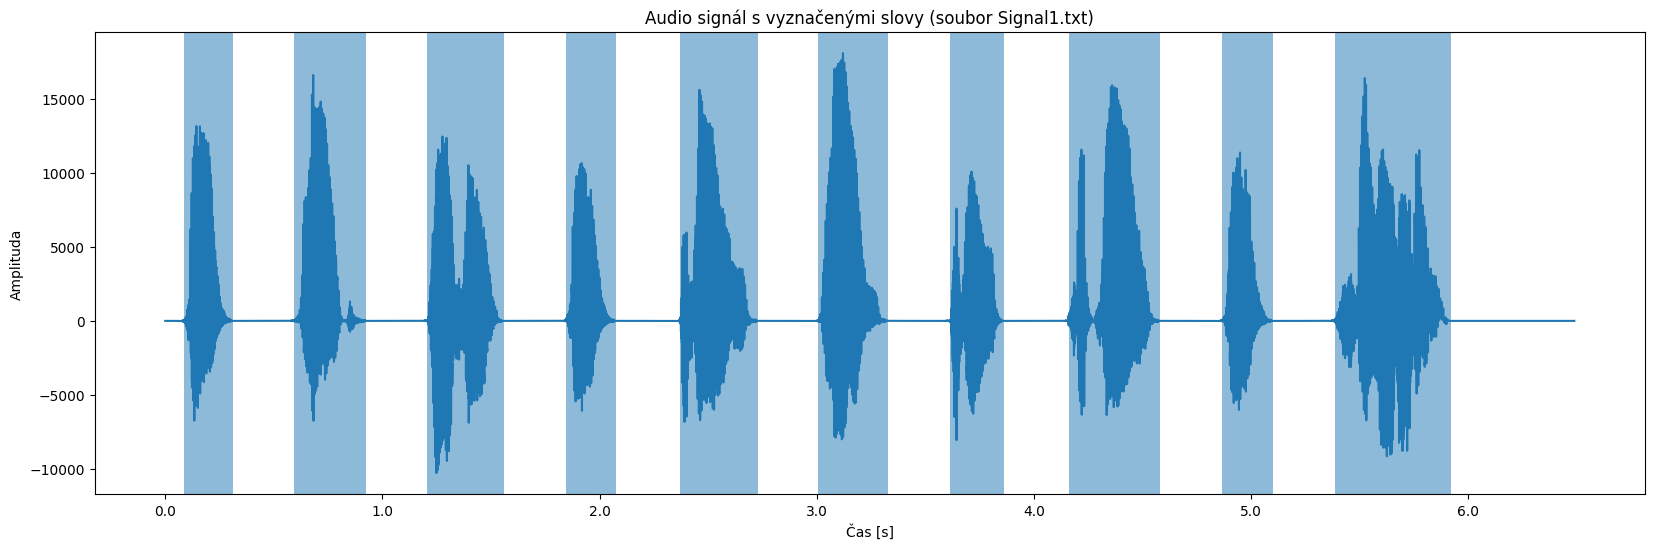

('the', 80.8) ('no', 29.2) ('easy', 18.7)
('work', 66.9) ('make', 35.1) ('no', 17.7)
('easy', 85.0) ('idea', 25.2) ('make', 20.6)
('the', 67.0) ('no', 31.7) ('long', 18.7)
('time', 63.9) ('give', 23.9) ('easy', 23.6)
('no', 41.7) ('work', 28.4) ('make', 24.5)
('the', 38.9) ('no', 27.0) ('time', 26.9)
('long', 31.9) ('idea', 31.0) ('prepare', 27.4)
('the', 66.5) ('no', 33.9) ('long', 18.0)
('solution', 36.6) ('for', 27.8) ('fail', 27.3)


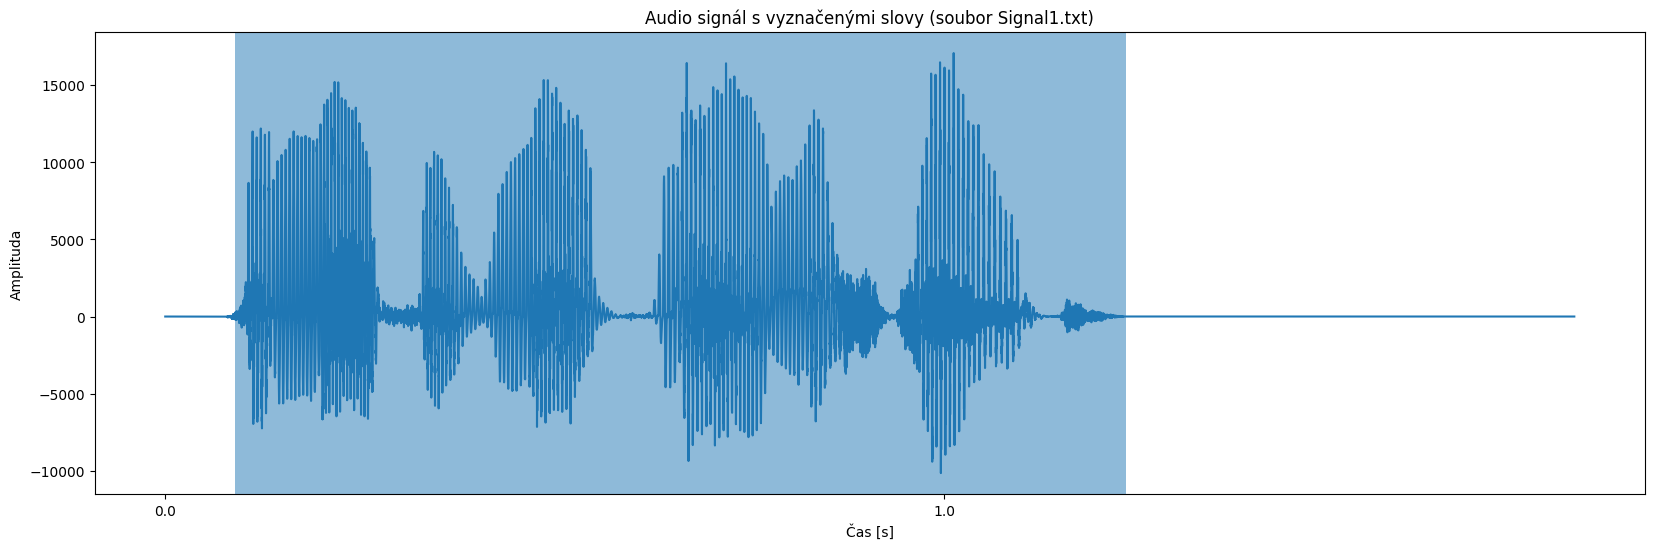

('probable', 30.3) ('method', 29.9) ('idea', 29.9)


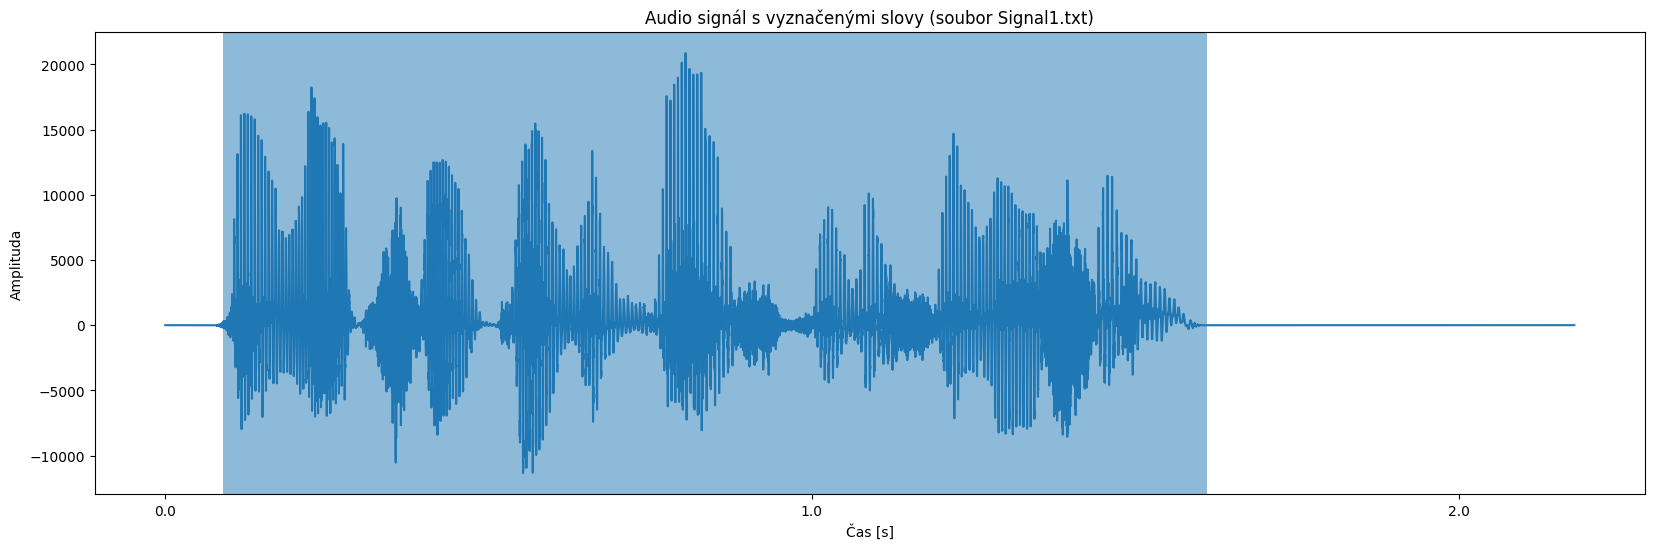

('method', 30.3) ('the', 30.0) ('idea', 29.8)


In [15]:
for path in ["Signal1.txt", "Signal2.txt", "Signal3.txt"]:
    word_data = []
    for word in word_list:
        input_file = os.path.join(directory, f"{word}.wav")
        signal, sampling_rate = load_wav_data(input_file)
        word_data.append((word, signal, sampling_rate))


    text_data = load_text_data(path)
    text_parts, text_regions = split_data_into_windows(text_data)


    plt.figure(figsize=(20, 6))
    plt.plot(text_data)

    for i, (start, end) in enumerate(text_regions):
        plt.axvspan(start, end, alpha=0.5)

    plt.xticks(np.arange(0, len(text_data), 22050), np.round(np.arange(0, len(text_data), 22050) / 22050, 1))
    plt.xlabel("Čas [s]")
    plt.ylabel("Amplituda")
    plt.title("Audio signál s vyznačenými slovy (soubor Signal1.txt)")
    plt.show()

    for target_part in text_parts:
        similarities = []
        
        for (word, reference_signal, reference_sampling_rate) in word_data:
            padded_reference, padded_target = pad_signals(reference_signal, target_part)
            
            mfccs_reference, sc_reference, chroma_reference = extract_audio_features(padded_reference, reference_sampling_rate)
            
            mfccs_target, sc_target, chroma_target = extract_audio_features(padded_target, 22050)
            
            dist_mfccs = calculate_spectral_distance(mfccs_reference, mfccs_target)
            dist_sc = calculate_spectral_distance(sc_reference, sc_target)
            dist_chroma = calculate_spectral_distance(chroma_reference, chroma_target)
            
            similarity = (dist_mfccs + dist_sc * 0.25 + dist_chroma * 0.1)
            similarities.append((word, similarity))
        
        top_guesses = word_statistics(similarities)
        print(*top_guesses)
        
        top3_guesses = sorted(similarities, key=lambda x: x[1])[:3]
        top3_guesses = [(x[0], np.round(x[1], 2)) for x in top3_guesses]